# In this notebook we show the basic experiment with our end-to-end Sinkhorn Autoencoder with Noise Generation, using standard MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import torchvision
import numpy as np
from geomloss import SamplesLoss
import pickle
import pandas as pd

In [4]:
torch.cuda.set_device(1)
device = torch.device("cuda") 
# device = torch.device("cpu")

In [2]:
batch_size = 1000
n_epochs = 20
input_size = 64

In [3]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
n_classes = len(train_dataset.classes)

### We define the archtitecture of our model as follows:

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim):
        super(Autoencoder, self).__init__()
        self.d = 64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d)
        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d)
        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear(self.d*9, self.d//4)

        self.fc1 = nn.Linear(self.d//4, self.d*4)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 4, 2, 0, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d*4)
        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 4, 2, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d*2)
        self.dc3 = nn.ConvTranspose2d( self.d * 2, self.d , 4, 1, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(self.d)
        self.dc4 = nn.ConvTranspose2d( self.d , 1, 4, 2, 0, bias=False)    
        

############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d*2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d)
        self.ng_fc2 = nn.Linear(self.d*3, self.d*4)
        self.ng_fc3 = nn.Linear(self.d*4, self.d*3)
        self.ng_fc4 = nn.Linear(self.d*3, self.d//4)
###############

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    
    # forward method
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(self.bn_1(x))
        x = self.conv2(x)
        x = F.leaky_relu(self.bn_2(x))
        x = self.conv3(x)
        x = F.leaky_relu(self.bn_3(x))
        x = x.view([-1,self.d*9])
        y = self.fc3(x)

        x = F.leaky_relu(self.fc1(y))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x = F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x)), y
    
    def generate(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x =F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x))
    
    def generate_noise(self, x, cond_x): 
        x = F.leaky_relu(self.ng_fc1(x), 0.2)
        x2 = F.leaky_relu(self.ng_input_2(cond_x), 0.2)
        x_concat = torch.cat((x,x2),1)
        x = F.leaky_relu(self.ng_fc2(x_concat), 0.2)
        x = F.leaky_relu(self.ng_fc3(x), 0.2)
        x = self.ng_fc4(x)
        return x
    
autoencoder = Autoencoder(input_size,n_classes).to(device)
autoencoder

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=576, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (dc1): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (dc1_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dc2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

### We use a standard MSE as a reconstruction loss

In [14]:
criterion_mse = nn.MSELoss()

### For the sinkhorn loss we use its implementation from the SamplesLoss package

In [15]:
loss_func = SamplesLoss("sinkhorn", blur=0.05,scaling = 0.95,diameter=0.01,debias=True)

### We use Adam as an opitmizer

In [16]:
lr = 0.0001
a_optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ExponentialLR(a_optimizer, gamma = 0.95)

### In this simple example we trian the model for 50 epochs
### Because of the big differences in losses we scale them by the factors specified below

In [17]:
n_epoch = 50
a_weigth = 1000
ng_weigth = 1 

In [19]:
autoencoder.train()
for epoch in range(1, n_epoch+1):      
    ng_losses = []
    a_losses = []
    mse_losses = []
    l2_loss = []
    for batch_idx, (x, cond_x) in enumerate(train_loader):
        x = x.to(device)
        y_onehot = torch.FloatTensor(batch_size, 10)
        y_onehot.zero_()
        cond_x = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1).to(device)
        autoencoder.zero_grad()

        autoencoder_output, y = autoencoder(x)
        
        ### STANDARD AUTOENCODER MSE loss
        a_loss_mse = criterion_mse(autoencoder_output, x)
        
        rand_x = torch.rand(batch_size, input_size).to(device) ### Generate input noise for the noise generator
        rand_y = autoencoder.generate_noise(rand_x,cond_x) ### Generate noise from random vector and conditional params
        ng_loss = loss_func(torch.cat([y,cond_x],1), torch.cat([rand_y,cond_x],1)) ### noise generator losss, 
            #conditional params added to compute also loss for generating noise close to this from other conditionals

        s_loss = ng_weigth*ng_loss+ a_weigth*a_loss_mse
        s_loss.backward()
        
        a_optimizer.step()
        a_losses.append(a_loss_mse)
        ng_losses.append(ng_loss)

    print('[%d/%d]: loss_ng: %.4f, loss_a: %.4f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(ng_losses)), torch.mean(torch.FloatTensor(a_losses))))#, torch.mean(torch.FloatTensor(mse_losses)), torch.mean(torch.FloatTensor(l2_loss))))
    scheduler.step()
#     print("lr:",scheduler.get_lr())

[1/50]: loss_ng: 0.8226, loss_a: 0.2516
[2/50]: loss_ng: 0.6625, loss_a: 0.1598
[3/50]: loss_ng: 0.5492, loss_a: 0.1203
[4/50]: loss_ng: 0.4806, loss_a: 0.1001
[5/50]: loss_ng: 0.4203, loss_a: 0.0875
[6/50]: loss_ng: 0.3669, loss_a: 0.0787
[7/50]: loss_ng: 0.3273, loss_a: 0.0722
[8/50]: loss_ng: 0.3049, loss_a: 0.0673
[9/50]: loss_ng: 0.2852, loss_a: 0.0633
[10/50]: loss_ng: 0.2720, loss_a: 0.0602
[11/50]: loss_ng: 0.2616, loss_a: 0.0575
[12/50]: loss_ng: 0.2534, loss_a: 0.0554
[13/50]: loss_ng: 0.2475, loss_a: 0.0534
[14/50]: loss_ng: 0.2420, loss_a: 0.0519
[15/50]: loss_ng: 0.2385, loss_a: 0.0506
[16/50]: loss_ng: 0.2349, loss_a: 0.0494
[17/50]: loss_ng: 0.2312, loss_a: 0.0483
[18/50]: loss_ng: 0.2287, loss_a: 0.0474
[19/50]: loss_ng: 0.2257, loss_a: 0.0465
[20/50]: loss_ng: 0.2234, loss_a: 0.0458
[21/50]: loss_ng: 0.2218, loss_a: 0.0452
[22/50]: loss_ng: 0.2202, loss_a: 0.0446
[23/50]: loss_ng: 0.2179, loss_a: 0.0439
[24/50]: loss_ng: 0.2158, loss_a: 0.0434
[25/50]: loss_ng: 0.2136,

### We plot the original images from the test dataset accompanied by their reconstructions with our autoencoder and random generations from the same class

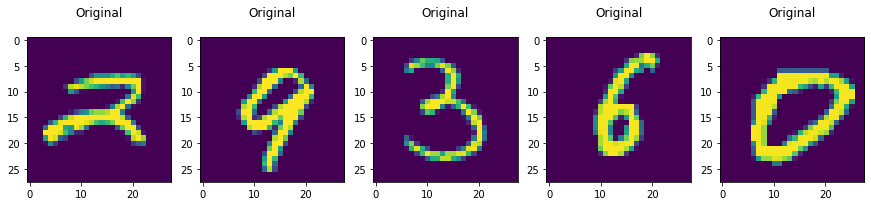

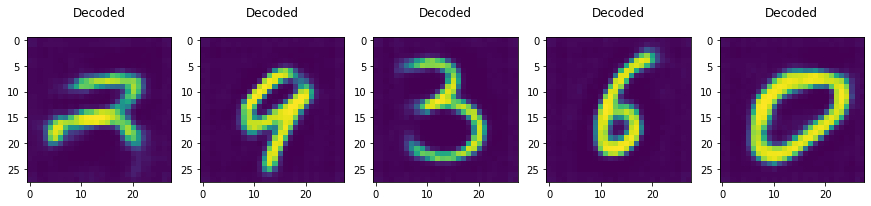

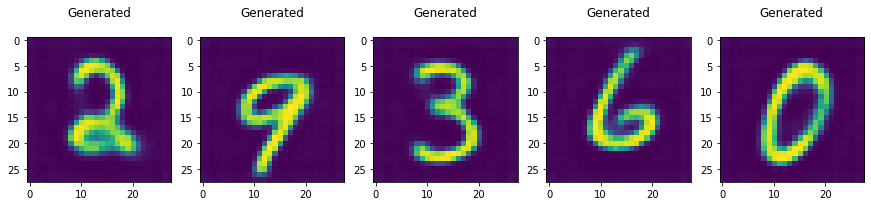

In [20]:
autoencoder.eval()
x, cond_x = next(iter(test_loader))
img_shape = [44,44]

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example = x[i:i+1]
    example = example.cpu().detach().numpy()
    example = example.squeeze()
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Original\n")
#     print()
plt.show()

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example,_ = autoencoder.forward(x[i:i+1].to(device))
    example = example.cpu().detach().numpy()
    example = example.squeeze()
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Decoded\n")
plt.show()

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    y_onehot = torch.FloatTensor(batch_size, 10)
    y_onehot.zero_()
    cond_s = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1)
#     generated_noise = ng.forward(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    generated_noise = autoencoder.generate_noise(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    example = autoencoder.generate(generated_noise)
    example = example.cpu().detach().numpy()
    example = example.squeeze()
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Generated\n")
plt.show()
